In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **기타 세팅**

- 모듈 불러오기

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.weightstats import ztest
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

- 한국어 폰트 다운

In [ ]:
!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 8, 'font.family': 'NanumGothic'})

# **데이터 전처리**

In [ ]:
pip install pandas_datareader

In [ ]:
import pandas as pd
import pandas_datareader as pdr

all = pd.read_csv('/content/drive/MyDrive/공모전 2024/예측모델/출생, 사망, 혼인, 이혼 월별.csv', encoding='cp949')
all['Unnamed: 2'] = all['Unnamed: 2'].str.replace('월', ' ')

baby = all[(all['Unnamed: 1']=='출생아수(명)') & (all['○ 월.분기.연간 인구동향(출생,사망,혼인,이혼) [명, 건]']=='전국')]
baby = baby[['Unnamed: 2', 'Unnamed: 3']]
baby = baby.rename(columns={'Unnamed: 2':'시점', 'Unnamed: 3':'출생아수'})
baby.drop(baby.index[0:228], axis=0, inplace=True)
baby['출생아수'] = baby['출생아수'].astype(int)

# 날짜로 지정
baby['시점'] = baby['시점'].str.replace('.', '-')
baby['시점'] = baby['시점'].str.strip()
baby['시점'] = pd.to_datetime(baby['시점'], format='%Y-%m')

baby.set_index('시점', inplace = True)

<ipython-input-119-86455025d8e4>:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  baby['시점'] = baby['시점'].str.replace('.', '-')


# **데이터 정상성 확인**

### **데이터 정상성 확인(baby)**

In [ ]:
baby.plot(figsize=[12, 8])

plt.show()  # -> 이 그래프는 등분산성 만족하지 않고 추세가 있으므로 비정상시계열임.

In [ ]:
# 더 정확하기 보기
result = seasonal_decompose(baby['출생아수'],
                            model = 'additive',
                            period = 20)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10,10)

In [ ]:
# 정상성 확인 시스템
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"] )

    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


## 귀무가설 (H0): 정상 시계열이다
## 대립가설 (H1): 정상 시계열이 아니다 <-- p-value 0.01

In [121]:
kpss_test(baby)  # <-- p-value 0.01이므로 대립가설을 채택함

Results of KPSS Test:
Test Statistic            2.105707
p-value                   0.010000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


<ipython-input-14-e49967f03bb4>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


### **데이터 로그변환 후 정상성 확인(baby_log)**

In [ ]:
baby_log = np.log(baby)

In [ ]:
baby_log.plot(figsize=[12, 8])

plt.show()  # -> 이 그래프는 등분산성을 만족하지만, 추세가 있으므로 비정상시계열임.

In [ ]:
# 더 정확하기 보기
result = seasonal_decompose(baby_log['출생아수'],
                            model = 'additive',
                            period = 20)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10,10)

In [ ]:
kpss_test(baby_log)  # p-value가 0.01이므로 비정상 시계열임 -> 차분 필요

### **로그변화 데이터 차분 후 정상성 확인(baby_diff)**

In [ ]:
baby_diff = baby_log.diff(1).dropna()

baby_diff.plot(figsize=(12, 8))
plt.title("De-trend by 1st order Differencing", fontsize=16)
plt.show()  # -> 추세 제거됨

In [ ]:
kpss_test(baby_diff) # p-value가 0.05보다 크므로 정상 시계열 -> 원데이터에서 로그변환 후 차분을 하면 정상성 시계열이 됨.

# **훈련용/검정용 데이터 나누기 (train, test)**

In [ ]:
plt.figure(figsize = (10,5))
train = baby['출생아수'][:int(0.8*len(baby))]
test = baby['출생아수'][int(0.8*len(baby)):]    # 훈련 데이터는 2018년 5월 전까지 검증용 데이터는 2018년 5월부터 2022년 12월까지
train.plot()
test.plot()

In [ ]:
plt.figure(figsize = (10,5))
train = baby_log['출생아수'][:int(0.8*len(baby))]
test = baby_log['출생아수'][int(0.8*len(baby)):]
train.plot()
test.plot()

# **시계열 예측모델 수립**

**최적의 시계열 모델 수립하기 > SARIMAX(1, 1, 1)x(1, 0, 1, 12)**

In [ ]:
# 최적 파라미터 서치

p = range(0, 2)
d = range(1, 3)
q = range(0, 2)
pdq = list(itertools.product(p, d, q))

AIC = []
for i in pdq :
    model = ARIMA(train.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

In [ ]:
# optimal paramter > [((0, 1, 1), -490.72)]
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

In [ ]:
model = ARIMA(train.values, order=(0, 1, 1))
model_fit = model.fit()
model_fit.summary()

Ljung-Box (Q):  
p-값이 0.05보다 크면 자기상관이 없다. (H0: 자기상관이 없음)

Jarque-Bera (JB):  
p-값이 0.05보다 크면 정규분포를 따름 (H0: 정규성을 따름)

Heteroskedasticity (H):  
p-값이 0.05보다 크면 잔차의 변동성이 크지 않음 (불규칙성X, H0: 불규칙X)

In [ ]:
mod = tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1, 0, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)
mod_fit = mod.fit()
print(mod_fit.summary())

In [ ]:
mod_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

# **검증용 데이터를 활용하여 모델의 정확도 확인**

predicted_values : 테스트 데이터 예측값  
confidence_intervals : 신뢰구간

In [ ]:
# 테스트 데이터에 대한 예측 수행
forecast_steps = len(test)  # 테스트 데이터 크기에 맞게 조절하세요
forecast = mod_fit.get_forecast(steps=forecast_steps)

# 예측된 값과 신뢰 구간 얻기
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# 예측된 값과 신뢰 구간을 출력하거나 필요에 따라 사용하세요
print("테스트 데이터에 대한 예측 값:")
print(predicted_values)
print("\n테스트 데이터에 대한 신뢰 구간:")
print(confidence_intervals)

In [ ]:
# 로그 변환 해제
original_predicted_values = np.exp(predicted_values)
original_train = np.exp(train)
original_test = np.exp(test)
original_confidence_intervals = np.exp(confidence_intervals)

In [ ]:
original_confidence_intervals

In [ ]:
y_predict = pd.DataFrame(original_predicted_values)
y_predict = y_predict.rename(columns={'predicted_mean':'test_출생아수'})
y_predict

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(original_train, label='Train')        # 훈련 데이터
plt.plot(original_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.fill_between(y_predict.index,
                 original_confidence_intervals['lower 출생아수'],
                 original_confidence_intervals['upper 출생아수'],
                 color='blue', alpha=0.2, label='95% Confidence Interval')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pd.Series(y_predict['test_출생아수']['2018-05-01':])  # 예측된 평균값
y_truth = pd.Series(baby['출생아수']['2018-05-01':]) # 실제 값 중 '2020-01' 이후의 부분
mse = ((y_forecasted - y_truth) ** 2).mean()  # MSE:예측값과 실제값의 차이 제곱
print('MSE {}'.format(round(mse, 2)))

MSE 621155.37


- 로그변환 데이터 예측 MSE

In [ ]:
y_forecasted = pd.Series(pd.DataFrame(predicted_values)['predicted_mean']['2018-05-01':])  # 예측된 평균값
y_truth = pd.Series(baby_log['출생아수']['2018-05-01':]) # 실제 값 중 '2020-01' 이후의 부분
mse = ((y_forecasted - y_truth) ** 2).mean()  # MSE:예측값과 실제값의 차이 제곱
print('MSE {}'.format(round(mse, 9)))

MSE 0.001246979


# **SARIMA 모델로 미래 출생아수 예측하기**

In [ ]:
pred_uc = mod_fit.get_forecast(steps=141)

In [ ]:
pred_uc = np.exp(pred_uc.predicted_mean)
pred_uc

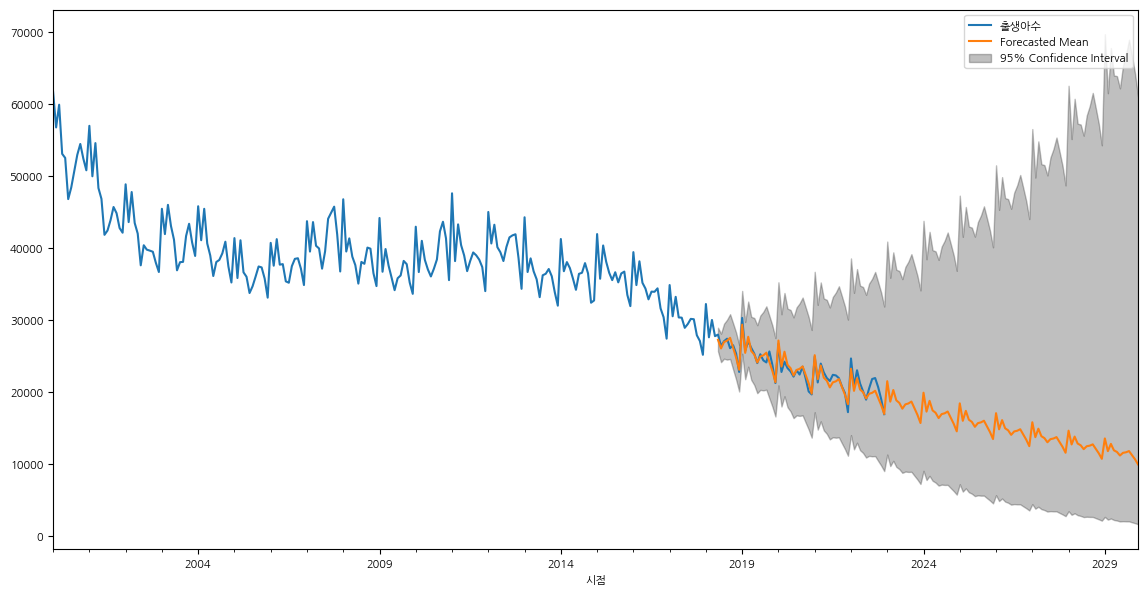

In [ ]:
# 예측 결과와 신뢰 구간 얻기
forecast = mod_fit.get_forecast(steps=140)
predicted_mean = forecast.predicted_mean
predicted_mean = np.exp(predicted_mean)

confidence_intervals = forecast.conf_int()
confidence_intervals = np.exp(confidence_intervals)

# 그래프
ax = baby.plot(label='observed', figsize=(14, 7))
predicted_mean.plot(ax=ax, label='Forecasted Mean')
ax.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='k', alpha=.25, label='95% Confidence Interval')

plt.legend()
plt.show()